<a href="https://colab.research.google.com/github/ZhiquanW/Learn-CUDA-Repository/blob/master/Copy_of_udacity_cs344_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd /content/
! rm -fr udacity-cs344-colab/
! ls

/content
sample_data


   Udacity Homework 3
   HDR Tone-mapping

  Background HDR
  ==============

  A High Dynamic Range (HDR) image contains a wider variation of intensity
  and color than is allowed by the RGB format with 1 byte per channel that we
  have used in the previous assignment.

  To store this extra information we use single precision floating point for
  each channel.  This allows for an extremely wide range of intensity values.

  In the image for this assignment, the inside of church with light coming in
  through stained glass windows, the raw input floating point values for the
  channels range from 0 to 275.  But the mean is .41 and 98% of the values are
  less than 3!  This means that certain areas (the windows) are extremely bright
  compared to everywhere else.  If we linearly map this [0-275] range into the
  [0-255] range that we have been using then most values will be mapped to zero!
  The only thing we will be able to see are the very brightest areas - the
  windows - everything else will appear pitch black.

  The problem is that although we have cameras capable of recording the wide
  range of intensity that exists in the real world our monitors are not capable
  of displaying them.  Our eyes are also quite capable of observing a much wider
  range of intensities than our image formats / monitors are capable of
  displaying.

  Tone-mapping is a process that transforms the intensities in the image so that
  the brightest values aren't nearly so far away from the mean.  That way when
  we transform the values into [0-255] we can actually see the entire image.
  There are many ways to perform this process and it is as much an art as a
  science - there is no single "right" answer.  In this homework we will
  implement one possible technique.

  Background Chrominance-Luminance
  ================================

  The RGB space that we have been using to represent images can be thought of as
  one possible set of axes spanning a three dimensional space of color.  We
  sometimes choose other axes to represent this space because they make certain
  operations more convenient.

  Another possible way of representing a color image is to separate the color
  information (chromaticity) from the brightness information.  There are
  multiple different methods for doing this - a common one during the analog
  television days was known as Chrominance-Luminance or YUV.

  We choose to represent the image in this way so that we can remap only the
  intensity channel and then recombine the new intensity values with the color
  information to form the final image.

  Old TV signals used to be transmitted in this way so that black & white
  televisions could display the luminance channel while color televisions would
  display all three of the channels.


  Tone-mapping
  ============

  In this assignment we are going to transform the luminance channel (actually
  the log of the luminance, but this is unimportant for the parts of the
  algorithm that you will be implementing) by compressing its range to [0, 1].
  To do this we need the cumulative distribution of the luminance values.

  Example
  -------

  input : [2 4 3 3 1 7 4 5 7 0 9 4 3 2]
  min / max / range: 0 / 9 / 9

  histo with 3 bins: [4 7 3]

  cdf : [4 11 14]


  Your task is to calculate this cumulative distribution by following these
  steps.


In [136]:
arr = [2, 4 ,3 ,3 ,1 ,7 ,4 ,5 ,7 ,0 ,9 ,4 ,3 ,2]
result = [];
for i in range(len(arr)):
    result.append(0);
for item in arr:
    index = int((item-0)/9*3);
    print(item/3);
    result[index]= result[index]+1;
for i in range(len(arr)):
    print(result[i])

0.6666666666666666
1.3333333333333333
1.0
1.0
0.3333333333333333
2.3333333333333335
1.3333333333333333
1.6666666666666667
2.3333333333333335
0.0
3.0
1.3333333333333333
1.0
0.6666666666666666
4
7
2
1
0
0
0
0
0
0
0
0
0
0


In [0]:
# Homework 3 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/depctg/udacity-cs344-colab
!pip install git+git://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "udacity-cs344-colab/src/HW3"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir udacity-cs344-colab/build
%cd udacity-cs344-colab/build
!cmake ../src

Cloning into 'udacity-cs344-colab'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 144 (delta 43), reused 100 (delta 28), pack-reused 0
Receiving objects: 100% (144/144), 3.94 MiB | 17.60 MiB/s, done.
Resolving deltas: 100% (43/43), done.
  Cloning git://github.com/depctg/nvcc4jupyter.git to /tmp/pip-req-build-0sfy11bt
  Running command git clone -q git://github.com/depctg/nvcc4jupyter.git /tmp/pip-req-build-0sfy11bt
  Stored in directory: /tmp/pip-ephem-wheel-cache-7j8xlz48/wheels/1e/43/2d/099cad2b9b02dfa88573f50a22735d8a0b2ba69bf82167b81c
Successfully built NVCCPlugin
Set up cuda environment at /content/udacity-cs344-colab/src/HW3
Default out bin result.out
/content/udacity-cs344-colab/build
-- The C compiler identification is GNU 7.3.0
-- The CXX compiler identification is GNU 7.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- wo

In [163]:

%%cuda --name student_func.cu
//%%cuda --name student_func.cu
/* Udacity Homework 3
   HDR Tone-mapping
  Background HDR
  ==============
  A High Dynamic Range (HDR) image contains a wider variation of intensity
  and color than is allowed by the RGB format with 1 byte per channel that we
  have used in the previous assignment.  
  To store this extra information we use single precision floating point for
  each channel.  This allows for an extremely wide range of intensity values.
  In the image for this assignment, the inside of church with light coming in
  through stained glass windows, the raw input floating point values for the
  channels range from 0 to 275.  But the mean is .41 and 98% of the values are
  less than 3!  This means that certain areas (the windows) are extremely bright
  compared to everywhere else.  If we linearly map this [0-275] range into the
  [0-255] range that we have been using then most values will be mapped to zero!
  The only thing we will be able to see are the very brightest areas - the
  windows - everything else will appear pitch black.
  The problem is that although we have cameras capable of recording the wide
  range of intensity that exists in the real world our monitors are not capable
  of displaying them.  Our eyes are also quite capable of observing a much wider
  range of intensities than our image formats / monitors are capable of
  displaying.
  Tone-mapping is a process that transforms the intensities in the image so that
  the brightest values aren't nearly so far away from the mean.  That way when
  we transform the values into [0-255] we can actually see the entire image.
  There are many ways to perform this process and it is as much an art as a
  science - there is no single "right" answer.  In this homework we will
  implement one possible technique.
  Background Chrominance-Luminance
  ================================
  The RGB space that we have been using to represent images can be thought of as
  one possible set of axes spanning a three dimensional space of color.  We
  sometimes choose other axes to represent this space because they make certain
  operations more convenient.
  Another possible way of representing a color image is to separate the color
  information (chromaticity) from the brightness information.  There are
  multiple different methods for doing this - a common one during the analog
  television days was known as Chrominance-Luminance or YUV.
  We choose to represent the image in this way so that we can remap only the
  intensity channel and then recombine the new intensity values with the color
  information to form the final image.
  Old TV signals used to be transmitted in this way so that black & white
  televisions could display the luminance channel while color televisions would
  display all three of the channels.
  
  Tone-mapping
  ============
  In this assignment we are going to transform the luminance channel (actually
  the log of the luminance, but this is unimportant for the parts of the
  algorithm that you will be implementing) by compressing its range to [0, 1].
  To do this we need the cumulative distribution of the luminance values.
  Example
  -------
  input : [2 4 3 3 1 7 4 5 7 0 9 4 3 2]
  min / max / range: 0 / 9 / 9
  histo with 3 bins: [4 7 3]
  cdf : [4 11 14]
  Your task is to calculate this cumulative distribution by following these
  steps.
*/

#include <limits.h>
#include <float.h>
#include <math.h>
#include <stdio.h>

#include "utils.h"

__global__
void histogram_kernel(unsigned int* d_bins, const float* d_in, const int bin_count, const float lum_min, const float lum_max, const int size) {  
    int mid = threadIdx.x + blockDim.x * blockIdx.x;
    if(mid >= size)
        return;
    float lum_range = lum_max - lum_min;
    int bin = ((d_in[mid]-lum_min) / lum_range) * bin_count;
    if(bin==bin_count){
        printf("%d %d %f\n",bin_count,d_bins[bin],d_in[mid]);
    }
    atomicAdd(&d_bins[bin], 1);
    if(d_bins[bin]<0){
        printf("%d %d %f\n",bin_count,d_bins[bin],d_in[mid]);
    }
}

__global__ 
void scan_kernel(unsigned int* d_bins, int size) {
    int mid = threadIdx.x + blockDim.x * blockIdx.x;
    if(mid >= size)
        return;
    
    for(int s = 1; s <= size; s *= 2) {
          int spot = mid - s; 
         
          unsigned int val = 0;
          if(spot >= 0)
              val = d_bins[spot];
          __syncthreads();
          if(spot >= 0)
              d_bins[mid] += val;
          __syncthreads();

    }
}
// calculate reduce max or min and stick the value in d_answer.
__global__
void reduce_minmax_kernel(const float* const d_in, float* d_out, const size_t size, int minmax) {
    extern __shared__ float shared[];
    
    int mid = threadIdx.x + blockDim.x * blockIdx.x;
    int tid = threadIdx.x; 
    
    // we have 1 thread per block, so copying the entire block should work fine
    if(mid < size) {
        shared[tid] = d_in[mid];
    } else {
        if(minmax == 0)
            shared[tid] = FLT_MAX;
        else
            shared[tid] = -FLT_MAX;
    }
    
    // wait for all threads to copy the memory
    __syncthreads();
    
    // don't do any thing with memory if we happen to be far off ( I don't know how this works with
    // sync threads so I moved it after that point )
    if(mid >= size) {   
        if(tid == 0) {
            if(minmax == 0) 
                d_out[blockIdx.x] = FLT_MAX;
            else
                d_out[blockIdx.x] = -FLT_MAX;

        }
        return;
    }
       
    for(unsigned int s = blockDim.x/2; s > 0; s /= 2) {
        if(tid < s) {
            if(minmax == 0) {
                shared[tid] = min(shared[tid], shared[tid+s]);
            } else {
                shared[tid] = max(shared[tid], shared[tid+s]);
            }
        }
        
        __syncthreads();
    }
    
    if(tid == 0) {
        d_out[blockIdx.x] = shared[0];
    }
}

int get_max_size(int n, int d) {
    return (int)ceil( (float)n/(float)d ) + 1;
}

float reduce_minmax(const float* const d_in, const size_t size, int minmax) {
    int BLOCK_SIZE = 32;
    // we need to keep reducing until we get to the amount that we consider 
    // having the entire thing fit into one block size
    size_t curr_size = size;
    float* d_curr_in;
    
    checkCudaErrors(cudaMalloc(&d_curr_in, sizeof(float) * size));    
    checkCudaErrors(cudaMemcpy(d_curr_in, d_in, sizeof(float) * size, cudaMemcpyDeviceToDevice));


    float* d_curr_out;
    
    dim3 thread_dim(BLOCK_SIZE);
    const int shared_mem_size = sizeof(float)*BLOCK_SIZE;
    
    while(1) {
        checkCudaErrors(cudaMalloc(&d_curr_out, sizeof(float) * get_max_size(curr_size, BLOCK_SIZE)));
        
        dim3 block_dim(get_max_size(size, BLOCK_SIZE));
        reduce_minmax_kernel<<<block_dim, thread_dim, shared_mem_size>>>(
            d_curr_in,
            d_curr_out,
            curr_size,
            minmax
        );
        cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

            
        // move the current input to the output, and clear the last input if necessary
        checkCudaErrors(cudaFree(d_curr_in));
        d_curr_in = d_curr_out;
        
        if(curr_size <  BLOCK_SIZE) 
            break;
        
        curr_size = get_max_size(curr_size, BLOCK_SIZE);
    }
    
    // theoretically we should be 
    float h_out;
    cudaMemcpy(&h_out, d_curr_out, sizeof(float), cudaMemcpyDeviceToHost);
    cudaFree(d_curr_out);
    return h_out;
}

void your_histogram_and_prefixsum(const float* const d_logLuminance,
                                  unsigned int* const d_cdf,
                                  float &min_logLum,
                                  float &max_logLum,
                                  const size_t numRows,
                                  const size_t numCols,
                                  const size_t numBins)
{
    const size_t size = numRows*numCols;
    min_logLum = reduce_minmax(d_logLuminance, size, 0);
    max_logLum = reduce_minmax(d_logLuminance, size, 1);
    
    printf("got min of %f\n", min_logLum);
    printf("got max of %f\n", max_logLum);
    printf("numBins %d\n", numBins);
    
    unsigned int* d_bins;
    size_t histo_size = sizeof(unsigned int)*numBins;

    checkCudaErrors(cudaMalloc(&d_bins, histo_size));    
    checkCudaErrors(cudaMemset(d_bins, 0, histo_size));  
    dim3 thread_dim(1024);
    dim3 hist_block_dim(get_max_size(size, thread_dim.x));
    histogram_kernel<<<hist_block_dim, thread_dim>>>(d_bins, d_logLuminance, numBins, min_logLum, max_logLum, size);
    cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

    unsigned int h_out[1024];
    cudaMemcpy(&h_out, d_bins, sizeof(unsigned int)*numBins, cudaMemcpyDeviceToHost);
    for(int i = 1023; i <= 1024; i++)
        printf("hist out %d\n", h_out[i]);
    
    dim3 scan_block_dim(get_max_size(numBins, thread_dim.x));

    scan_kernel<<<scan_block_dim, thread_dim>>>(d_bins, numBins);
    cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());
    
    cudaMemcpy(&h_out, d_bins, sizeof(unsigned int)*100, cudaMemcpyDeviceToHost);
  //  for(int i = 0; i < 100; i++)
  //      printf("cdf out %d\n", h_out[i]);
    

    cudaMemcpy(d_cdf, d_bins, histo_size, cudaMemcpyDeviceToDevice);

    
    checkCudaErrors(cudaFree(d_bins));
     
    
  //TODO
  /*Here are the steps you need to implement
    1) find the minimum and maximum value in the input logLuminance channel
       store in min_logLum and max_logLum
    2) subtract them to find the range
    3) generate a histogram of all the values in the logLuminance channel using
       the formula: bin = (lum[i] - lumMin) / lumRange * numBins
    4) Perform an exclusive scan (prefix sum) on the histogram to get
       the cumulative distribution of luminance values (this should go in the
       incoming d_cdf pointer which already has been allocated for you)       */
}

'File written in /content/udacity-cs344-colab/src/HW3/student_func.cu'

In [164]:
# make the cuda project
!make HW3
print("\n====== RESULT OF HW3 =======\n")
!bin/HW3 ../src/HW3/memorial_png_large.gold

[ 14%] Building NVCC (Device) object HW3/CMakeFiles/HW3.dir/HW3_generated_student_func.cu.o
/content/udacity-cs344-colab/src/HW3/student_func.cu(81): warning: pointless comparison of unsigned integer with zero

/content/udacity-cs344-colab/src/HW3/student_func.cu(81): warning: pointless comparison of unsigned integer with zero

/content/udacity-cs344-colab/src/HW3/student_func.cu(81): warning: pointless comparison of unsigned integer with zero

/content/udacity-cs344-colab/src/HW3/student_func.cu: In function ‘float reduce_minmax(const float*, size_t, int)’:
/content/udacity-cs344-colab/src/HW3/student_func.cu:193:15: warning: comparison between signed and unsigned integer expressions [-Wsign-compare]
         if(curr_size <  BLOCK_SIZE)
         ~~~~~~^~~~~~~~~~~~
/content/udacity-cs344-colab/src/HW3/student_func.cu: In function ‘void your_histogram_and_prefixsum(const float*, unsigned int*, float&, float&, size_t, size_t, size_t)’:
/content/udacity-cs344-colab/src/HW3/student_func.cu

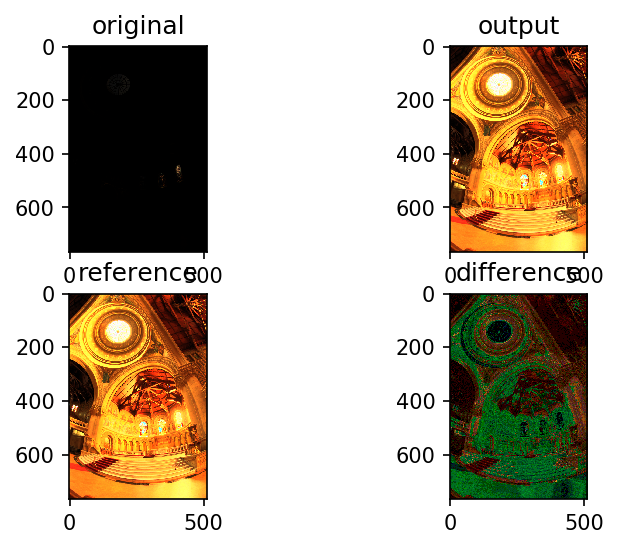

In [165]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(2,2, dpi=150)

ax[0][0].imshow(plt.imread("../src/HW3/memorial_raw_large.png"))
ax[0][0].set_title("original")
ax[0][0].grid(False)

ax[0][1].imshow(plt.imread("HW3_output.png"))
ax[0][1].set_title("output")
ax[0][1].grid(False)

ax[1][0].imshow(plt.imread("HW3_reference.png"))
ax[1][0].set_title("reference")
ax[1][0].grid(False)

ax[1][1].imshow(plt.imread("HW3_differenceImage.png"))
ax[1][1].set_title("difference")
ax[1][1].grid(False)

plt.show()